In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import cv2
from IPython.display import set_matplotlib_formats, HTML, Image, display
from loaders import load_all_videos, load_thumbnails, each_thumbnail, create_thumbs_df, load_thumbnail
from tqdm import notebook

%matplotlib inline
# set_matplotlib_formats('svg')

tqdm.notebook.tqdm().pandas()

sns.set()

def imshow(bgr):
    _,ret = cv2.imencode('.png', bgr)
    i = Image(data=ret)
    display(i)

def collage(images, rows=10, cols=10):
    w, h, d = sample[0].shape
    return np.array(sample).reshape(rows, cols, w, h, d).swapaxes(1, 2).reshape(rows * w, cols * h, d)

In [2]:
vids = load_all_videos()
load_thumbnails(vids)

100%|██████████| 8607/8607 [00:04<00:00, 2026.82it/s]

Downloaded: 0
Broken links: 0
Already present: 7928
Skipped: 679


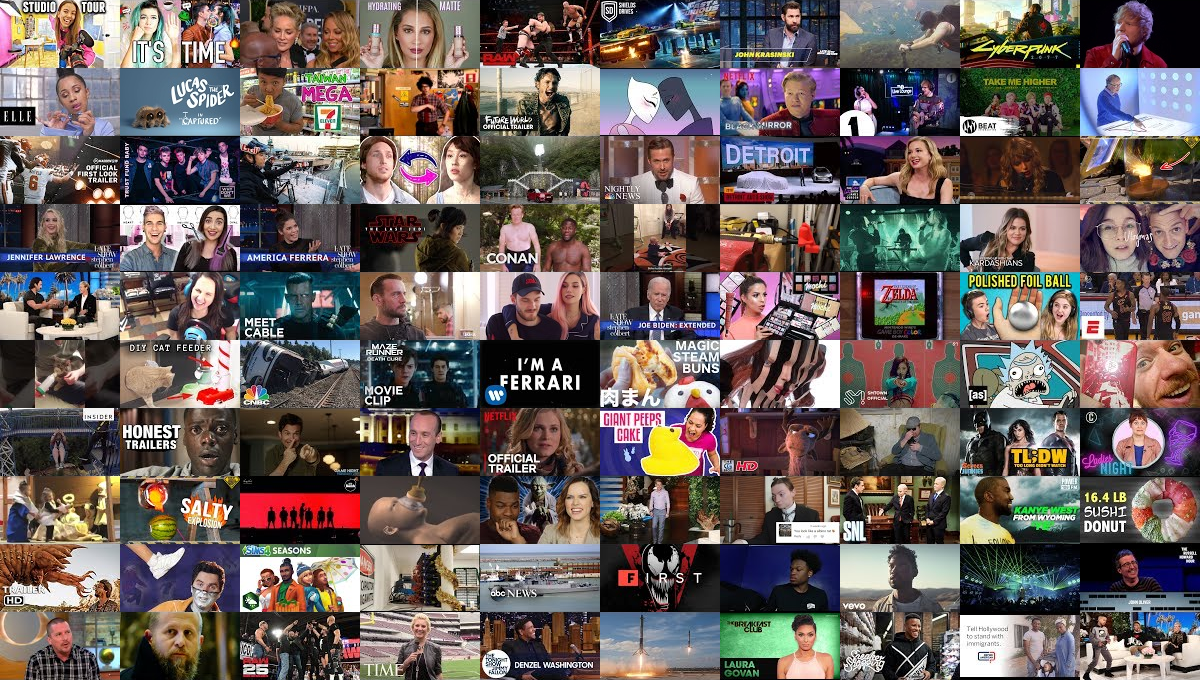

In [3]:
rows = 10
cols = 10
sample = [image for _, image in each_thumbnail(rows * cols)]
imshow(collage(sample))

## Color palette analysis

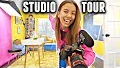

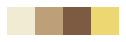

[Hsl(h=32, s=136, l=227), Hsl(h=24, s=89, l=155), Hsl(h=18, s=77, l=95), Hsl(h=35, s=194, l=175)]


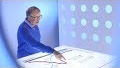

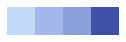

[Hsl(h=151, s=208, l=222), Hsl(h=158, s=170, l=200), Hsl(h=158, s=129, l=177), Hsl(h=162, s=116, l=114)]


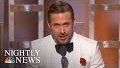

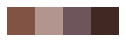

[Hsl(h=10, s=78, l=98), Hsl(h=8, s=46, l=159), Hsl(h=244, s=31, l=97), Hsl(h=7, s=81, l=50)]


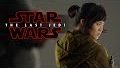

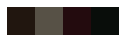

[Hsl(h=16, s=95, l=24), Hsl(h=27, s=27, l=78), Hsl(h=249, s=133, l=23), Hsl(h=95, s=46, l=11)]


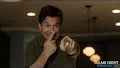

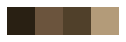

[Hsl(h=25, s=93, l=30), Hsl(h=21, s=69, l=84), Hsl(h=24, s=79, l=61), Hsl(h=24, s=70, l=150)]


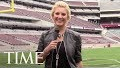

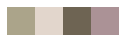

[Hsl(h=33, s=41, l=154), Hsl(h=19, s=70, l=215), Hsl(h=26, s=35, l=96), Hsl(h=248, s=33, l=158)]


In [4]:
import PIL
import colorgram

test = [sample[i] for i in [0, 19, 25, 33, 62, 93]]

def extract_palette(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    img = PIL.Image.fromarray(rgb)
    return colorgram.extract(img, 4)

def show_palette(palette):
    swatch = np.array([[list(color.rgb) for color in palette]])
    plt.figure(figsize=(2,8))
    plt.imshow(swatch)
    plt.axis('off')
    plt.show()

for image in test:
    palette = extract_palette(image)
    imshow(image)
    show_palette(palette)
    print([color.hsl for color in palette])

In [5]:
thumbs = create_thumbs_df()
thumbs

video_id
0     Cs2Xr2b7ako
1     Di4QJUCElgs
2     i6htP19PyEU
3     ZYXIAzqOgoY
4     mCx26FLXWuI
...           ...
7923  nQ7mhC5_Rys
7924  akohTFyGu88
7925  i9EyFghIt5o
7926  6uJf2IT2Zh8
7927  VTVLcK2zybM

[7928 rows x 1 columns]

In [6]:
hsl_zeros = { f"{x}{i}": 0 for i in range(4) for x in ['h', 's', 'l'] }
thumbs = thumbs.assign(**hsl_zeros)

def hsl_attributes(row):
    im = load_thumbnail(row['video_id'])
    for i, color in enumerate(extract_palette(im)):
        row[f"h{i}"] = int(color.hsl.h / 255 * 360)
        row[f"s{i}"] = int(color.hsl.s / 255 * 100)
        row[f"l{i}"] = int(color.hsl.l / 255 * 100)
    return row

thumbs = thumbs.progress_apply(hsl_attributes, axis=1)
thumbs

100%|██████████| 7928/7928 [04:46<00:00, 27.62it/s]


video_id   h0  s0  l0   h1  s1  l1   h2  s2  l2   h3  s3  l3
0     Cs2Xr2b7ako   45  53  89   33  34  60   25  30  37   49  76  68
1     Di4QJUCElgs   32  53  87   25  27  64   19  56  12   16  34  38
2     i6htP19PyEU   19  32  36   25  46  14  231  10  14   16  39  60
3     ZYXIAzqOgoY   21  23  61   31  17  40  100   6  44   28  42  15
4     mCx26FLXWuI   11  53   7  347  47   8    8  28  38  227  16   5
...           ...  ...  ..  ..  ...  ..  ..  ...  ..  ..  ...  ..  ..
7923  nQ7mhC5_Rys  299  37  94  232   8  62  227   6  41   49   6  36
7924  akohTFyGu88  240  10  96  338  71  95    8  69  96  355  78  55
7925  i9EyFghIt5o  194  49  56  194  67  45  194  70  40  145  12  57
7926  6uJf2IT2Zh8    0  20   2  197  18  10  347  44  10  163  11   6
7927  VTVLcK2zybM   28  19  36   26  25  15   22  21  61   28  44  86

[7928 rows x 13 columns]

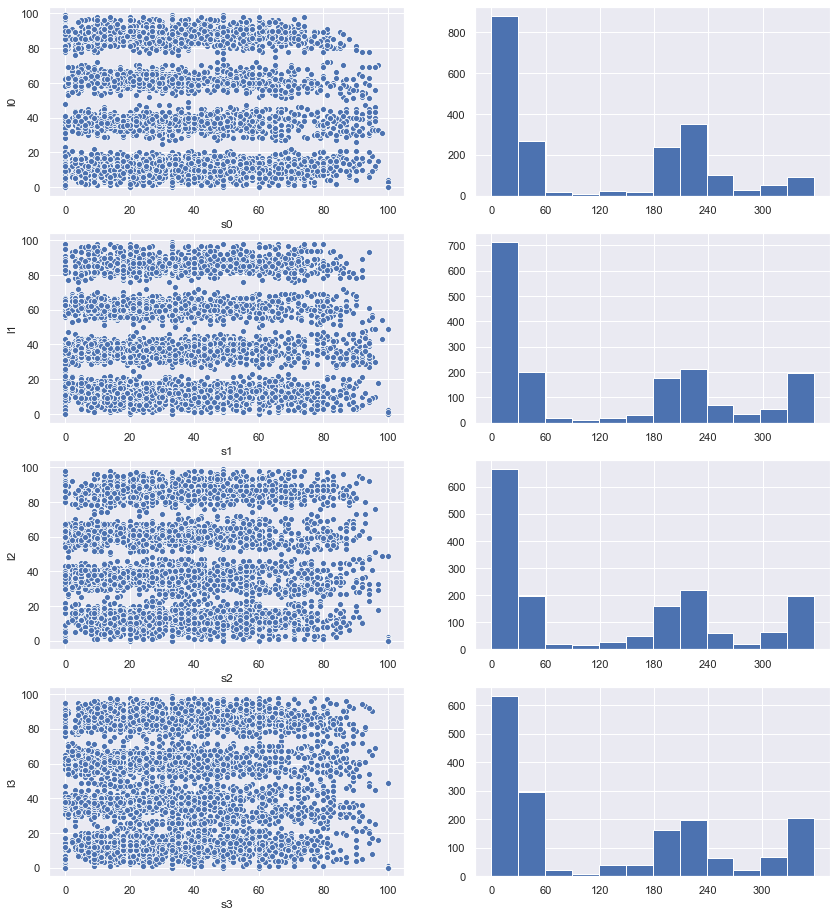

In [7]:
plt.figure(figsize=(14, 16))
for i in range(4):
    plt.subplot(4, 2, 2*i+1)
    sns.scatterplot(x=f"s{i}", y=f"l{i}", data=thumbs)
    plt.subplot(4, 2, 2*i+2)
    sl_filter = (thumbs[f"s{i}"] > 40) & (thumbs[f"s{i}"] > 30) & (thumbs[f"s{i}"] < 70)
    plt.hist(thumbs[sl_filter][f"h{i}"], bins=12)
    plt.xticks(np.arange(6) * 60)
plt.show()

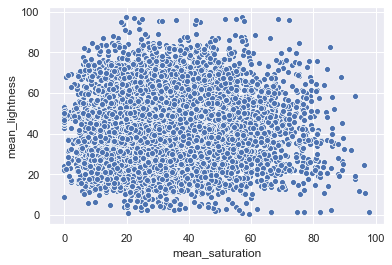

In [8]:
thumbs['mean_saturation'] = (thumbs['s0'] + thumbs['s1'] + thumbs['s2'] + thumbs['s3']) / 4
thumbs['mean_lightness'] = (thumbs['l0'] + thumbs['l1'] + thumbs['l2'] + thumbs['l3']) / 4

sns.scatterplot(x='mean_saturation', y='mean_lightness', data=thumbs)

(array([2536.,  762.,  477.,  325.,  249.,  228.,  288.,  497.,  848.,
        1718.]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.]),
 <a list of 10 Patch objects>)

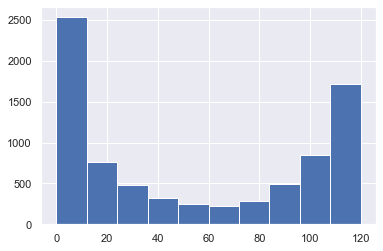

In [9]:
def hue_diff(a, b):
    diff = (a - b).abs()
    return np.array([diff, 360 - diff]).min(axis=0)

h01 = hue_diff(thumbs['h0'], thumbs['h1'])
h12 = hue_diff(thumbs['h1'], thumbs['h2'])
h20 = hue_diff(thumbs['h2'], thumbs['h0'])

mean_hue_diff = (h01 + h12 + h20) / 3
plt.hist(mean_hue_diff)

# Face analysis

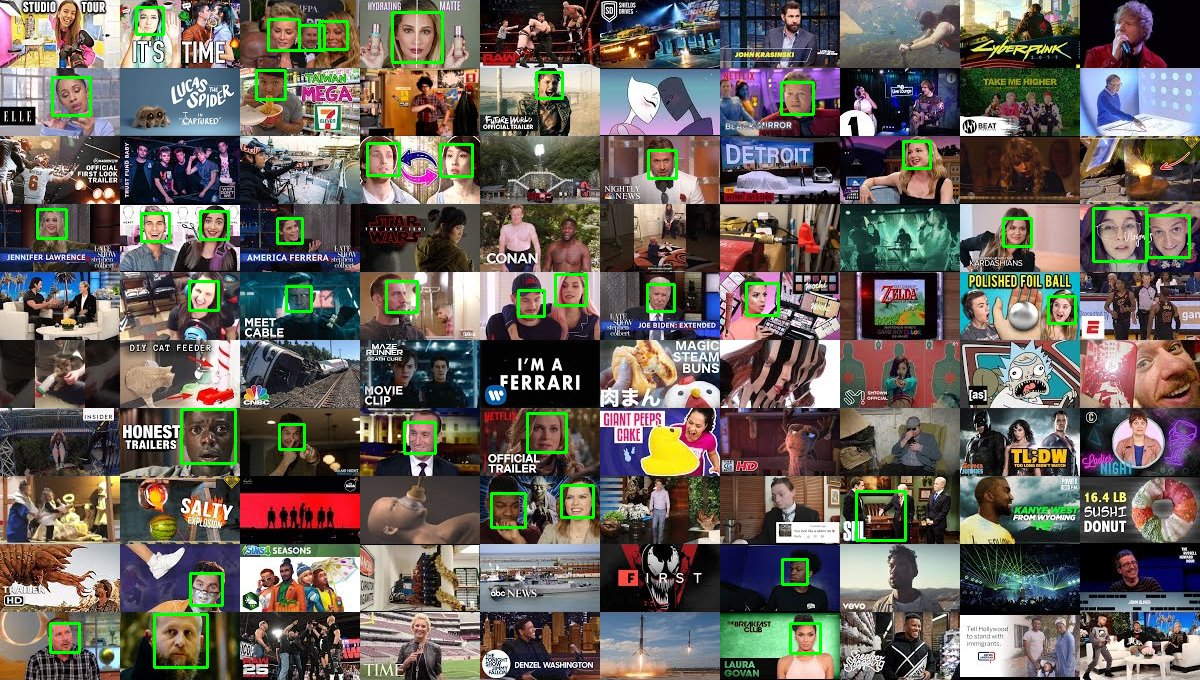

In [10]:
def detect_faces(thumbs):
    face_cascade = cv2.CascadeClassifier('../youtube_data/haarcascade_frontalface_default.xml')
    results = []
    for img in thumbs:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.05, 3)
        
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        results.append(img)
    return results
    
rows = 10
cols = 10
sample = [image for _, image in each_thumbnail(rows * cols)]
sample = detect_faces(sample)

imshow(collage(sample))

In [11]:
thumbs = create_thumbs_df()
thumbs

video_id
0     Cs2Xr2b7ako
1     Di4QJUCElgs
2     i6htP19PyEU
3     ZYXIAzqOgoY
4     mCx26FLXWuI
...           ...
7923  nQ7mhC5_Rys
7924  akohTFyGu88
7925  i9EyFghIt5o
7926  6uJf2IT2Zh8
7927  VTVLcK2zybM

[7928 rows x 1 columns]

In [12]:
face_cascade = cv2.CascadeClassifier('../youtube_data/haarcascade_frontalface_default.xml')

def detect_faces(row):
    img = load_thumbnail(row['video_id'])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    row['faces'] = faces
    row['faces_count'] = len(faces)
    
    return row

thumbs = thumbs.progress_apply(detect_faces, axis=1)
thumbs

100%|██████████| 7928/7928 [01:05<00:00, 121.32it/s]


video_id               faces  faces_count
0     Cs2Xr2b7ako                  ()            0
1     Di4QJUCElgs   [[16, 7, 27, 27]]            1
2     i6htP19PyEU  [[27, 19, 31, 31]]            1
3     ZYXIAzqOgoY  [[32, 12, 50, 50]]            1
4     mCx26FLXWuI                  ()            0
...           ...                 ...          ...
7923  nQ7mhC5_Rys                  ()            0
7924  akohTFyGu88                  ()            0
7925  i9EyFghIt5o                  ()            0
7926  6uJf2IT2Zh8                  ()            0
7927  VTVLcK2zybM                  ()            0

[7928 rows x 3 columns]

0    6294
1    1445
2     173
3      16
Name: faces_count, dtype: int64
Thumbs with at least one face: 1634 (20.61% of all)


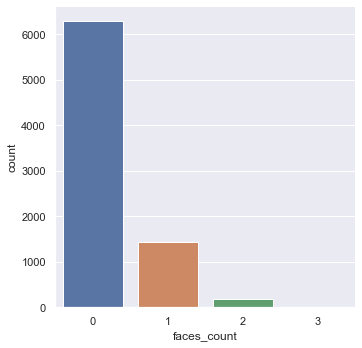

In [13]:
# how many thumbs have faces?
faces_per_thumb = thumbs['faces_count']

print(faces_per_thumb.value_counts())
sns.catplot(x="faces_count", kind="count", data=thumbs)

thumbs_with_faces = faces_per_thumb.where(faces_per_thumb > 0).count()
faces_ratio = round((thumbs_with_faces / len(thumbs) * 100), 3)
print("Thumbs with at least one face: " + str(thumbs_with_faces) + " (" + str(faces_ratio) + "% of all)")

In [17]:
# Can we detect faces?

from keras.models import load_model

classifier = load_model('../youtube_data/model_v6_23.hdf5')
class_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

In [62]:
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from collections import Counter

def detect_emotions(row):
    img = load_thumbnail(row['video_id'])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    rois = []
    for face in row['faces']:
        (x,y,w,h) = face
        roi_gray = gray[y:y+h, x:x+w]
        
        try:
            roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        except:
            roi_gray = np.zeros((48,48), np.uint8)
        
        rois.append(roi_gray)
        
    emotions = Counter()
    for roi in rois:
        if np.sum([roi]) == 0.0:
            print("Incorrect ROI for id:" + row['video_id'])
            continue
        
        roi = roi.astype("float")
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]
        
        emotions[label] += 1
    row['emotions'] = emotions
    
    return row

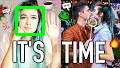

/Users/matis/Studia/3rd-sem/PED/youtube-trending-prediction/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Counter({'Fear': 1})

In [63]:
# Let's test it!

def test_face_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('../youtube_data/haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.05, 3)

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return img

test_thumb = thumbs.loc[1]
img = load_thumbnail(test_thumb['video_id'])

face = test_face_detection(img)
imshow(face)

detect_emotions(test_thumb)['emotions']

In [64]:
thumbs = thumbs.progress_apply(detect_emotions, axis=1)
thumbs['emotions'].value_counts()

TypeError: unhashable type: 'Counter'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'Counter'


{}                                        6294
{'Fear': 1}                                701
{'Surprise': 1}                            388
{'Happy': 1}                               204
{'Angry': 1}                               152
{'Fear': 2}                                 48
{'Surprise': 1, 'Fear': 1}                  37
{'Surprise': 2}                             21
{'Happy': 1, 'Fear': 1}                     20
{'Angry': 1, 'Fear': 1}                     13
{'Happy': 2}                                10
{'Surprise': 1, 'Happy': 1}                  9
{'Angry': 2}                                 6
{'Fear': 2, 'Surprise': 1}                   5
{'Surprise': 1, 'Angry': 1}                  5
{'Surprise': 2, 'Fear': 1}                   5
{'Happy': 1, 'Angry': 1}                     4
{'Happy': 1, 'Fear': 2}                      1
{'Surprise': 3}                              1
{'Angry': 2, 'Fear': 1}                      1
{'Happy': 1, 'Surprise': 1, 'Fear': 1}       1
{'Angry': 1, 

In [72]:
thumbs['emotions'].value_counts()

TypeError: unhashable type: 'Counter'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'Counter'


{}                                        6294
{'Fear': 1}                                701
{'Surprise': 1}                            388
{'Happy': 1}                               204
{'Angry': 1}                               152
{'Fear': 2}                                 48
{'Surprise': 1, 'Fear': 1}                  37
{'Surprise': 2}                             21
{'Happy': 1, 'Fear': 1}                     20
{'Angry': 1, 'Fear': 1}                     13
{'Happy': 2}                                10
{'Surprise': 1, 'Happy': 1}                  9
{'Angry': 2}                                 6
{'Fear': 2, 'Surprise': 1}                   5
{'Surprise': 1, 'Angry': 1}                  5
{'Surprise': 2, 'Fear': 1}                   5
{'Happy': 1, 'Angry': 1}                     4
{'Happy': 1, 'Fear': 2}                      1
{'Surprise': 3}                              1
{'Angry': 2, 'Fear': 1}                      1
{'Happy': 1, 'Surprise': 1, 'Fear': 1}       1
{'Angry': 1, 

## Text detection

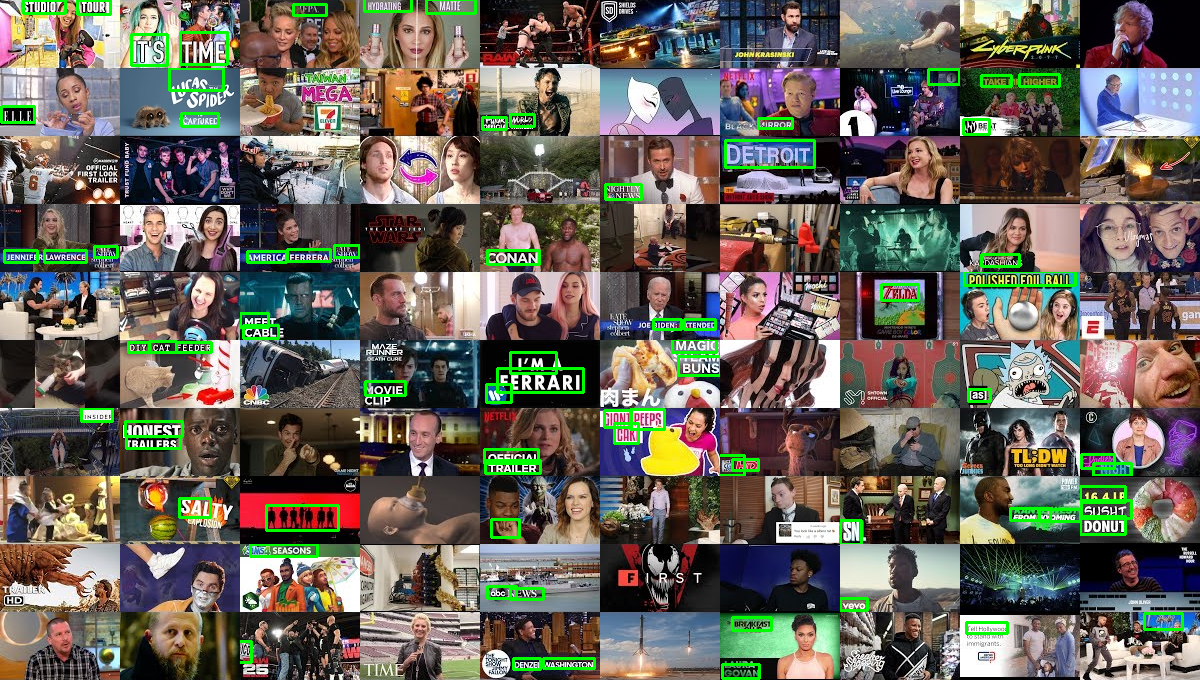

In [14]:
from text_detection import find_text, draw_bounding_boxes, boxes_area

sample = [image for _, image in each_thumbnail(rows * cols)]

for img in sample:
    boxes = find_text(img)
    draw_bounding_boxes(img, boxes)

imshow(collage(sample))

In [15]:
def detect_text(row):
    img = load_thumbnail(row['video_id'])
    boxes = find_text(img)
    row['text_area'] = boxes_area(img, boxes)
    return row

thumbs = thumbs.progress_apply(detect_text, axis=1)
thumbs

 32%|███▏      | 2544/7928 [02:35<07:29, 11.97it/s]

KeyboardInterrupt: 

In [ ]:
thumbs['text_area'].describe()

In [ ]:
has_text = thumbs['text_area'] > 0
dist = thumbs.groupby(has_text).size()
print(dist)
sns.barplot(dist.index, dist.values)

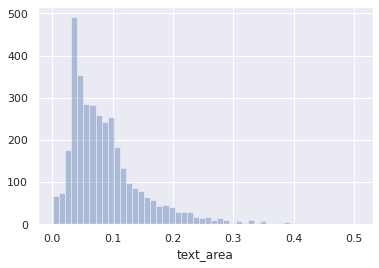

In [63]:
thumbs_with_text = thumbs[has_text]
sns.distplot(thumbs_with_text['text_area'], kde=False)